In [11]:
import os
# print(os.getcwd())
os.chdir("..")
print(os.getcwd())

/home/b/b382119/AQUA/diagnostics/global_ocean


In [12]:
%load_ext autoreload
%autoreload 2
from aqua import Reader,catalogue, inspect_catalogue
import global_ocean_func as fn
from aqua.util import load_yaml

FDB5 binary library not present on system, disabling FDB support.


In [13]:
# Here we read one of the reference NextGEMS Cycle 3 simulations
reader = Reader(model='FESOM', exp='tco2559-ng5-cycle3', source="lra-r100-monthly")

# And we extract the Potential Temperature and Practical Salinity fields, resampling in yearly means
# Yearly means are more adequate to identify  drifts as they are not contaminated by seasonal cycle signals
yearly_data = reader.retrieve()[["ocpt","so"]].resample(time="Y").mean()
yearly_data=yearly_data.rename({"nz1":"lev"})

In [4]:
config = load_yaml("config.yaml")
outputfig= config["outputfig"]

2023-07-07 13:39:14,325 - INFO -  data slicing for this region, latitude -90.0 to 90.0, longitude 0.0 to 360.0


2023-07-07 13:39:37,277 - INFO - ./figs/TS_anomalies_global_ocean.png saved
2023-07-07 13:39:37,279 - INFO -  data slicing for this region, latitude -90.0 to 90.0, longitude 0.0 to 360.0
2023-07-07 13:39:54,963 - INFO - ./figs/TS_anomalies_global_ocean.png saved
2023-07-07 13:39:54,964 - INFO -  data slicing for this region, latitude -90.0 to 90.0, longitude 0.0 to 360.0
2023-07-07 13:40:12,568 - INFO - ./figs/TS_anomalies_global_ocean.png saved


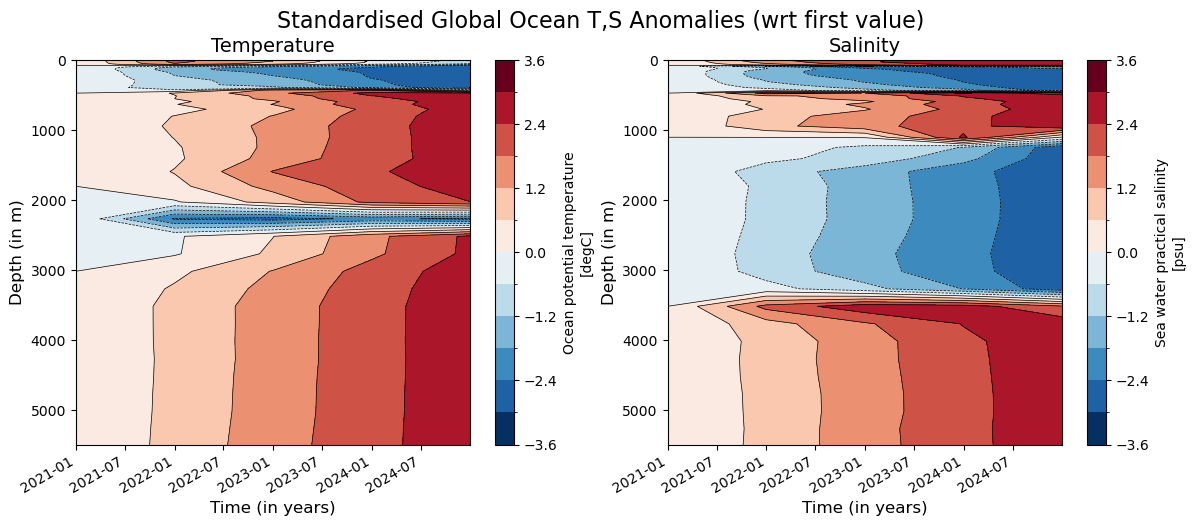

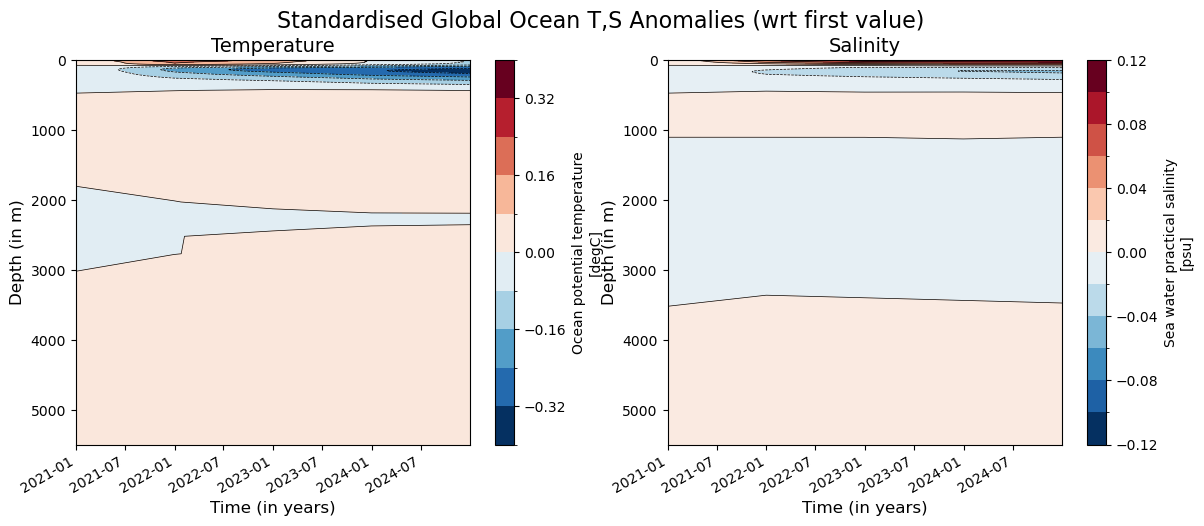

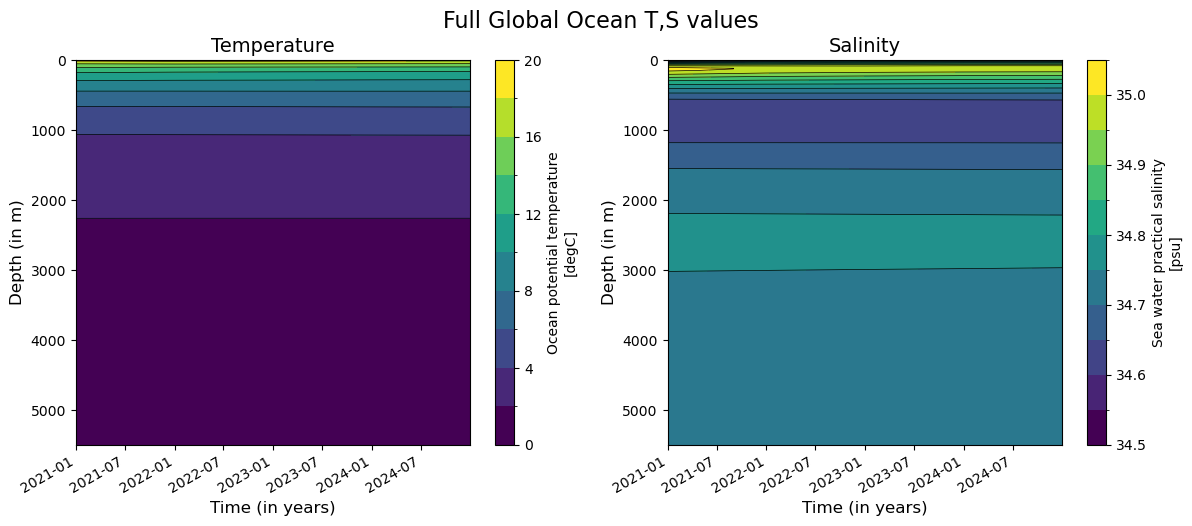

In [5]:
# We first focus on the GLOBAL OCEAN
 
# This function computes normalized anomalies as a function of depth and time
#  The anomalies are computed with respect to the first value (at t=0)
global_mean_anom_t0_std = fn.std_anom_wrt_initial(yearly_data, region="Global Ocean")
## IDEALLY WE COULD ADD THE OPTION OF ALLOWING THE USER TO CHOOSE IF THE ANOMALY IS COMPUTED AGAINST THE
##  FIRST VALUE, THE MEAN OF THE WHOLE PERIOD, OR THE MEAN OF A SELECTED PERIOD
# This function produces the respective figure
fn.ocpt_so_std_plot(global_mean_anom_t0_std ,"Global Ocean", outputfig)
# These functions produce an alternative version of non-normalized anomalies and plot them
global_mean_anom_t0  = fn.anom_wrt_initial(yearly_data, region="Global Ocean")
fn.ocpt_so_anom_plot(global_mean_anom_t0 ,"Global Ocean", outputfig)
## ADDING LOGARITHMIC SCALE OPTION TO COLORBAR IN ocpt_so_anom_plot
# Finally these functions complute the globally averaged full fields of T,S
# and plot them (It is less useful as the ocean is very stratified and drifts are less visible)
global_mean  = fn.reg_mean(yearly_data, region="Global Ocean")
fn.ocpt_so_full_plot(global_mean ,"Global Ocean", outputfig)




2023-07-07 13:29:41,578 - INFO - ./figs/TS_time_series_anomalies_global_ocean.png saved


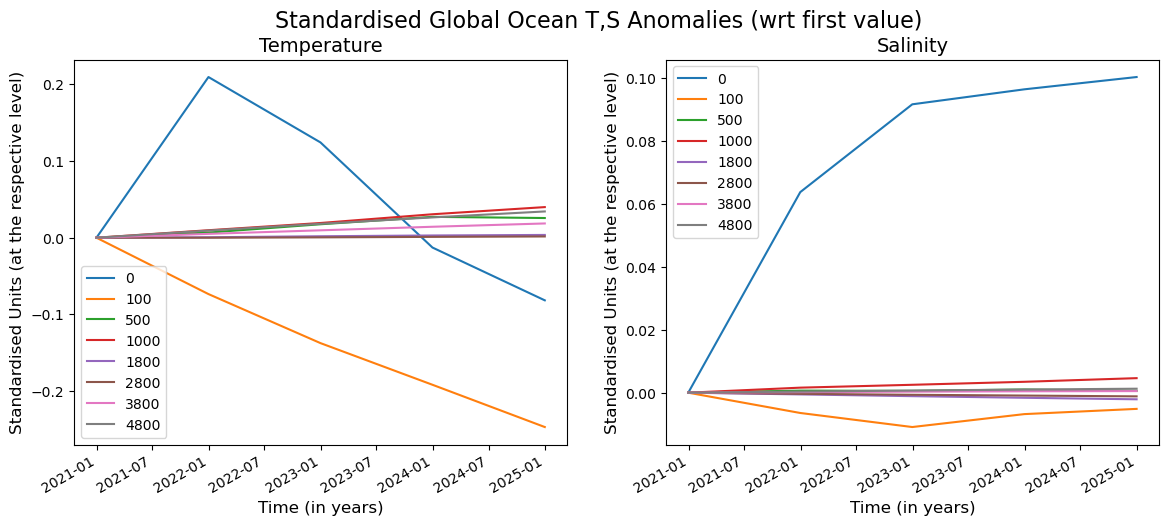

2023-07-07 13:30:57,767 - INFO - ./figs/TS_time_series_anomalies_global_ocean.png saved


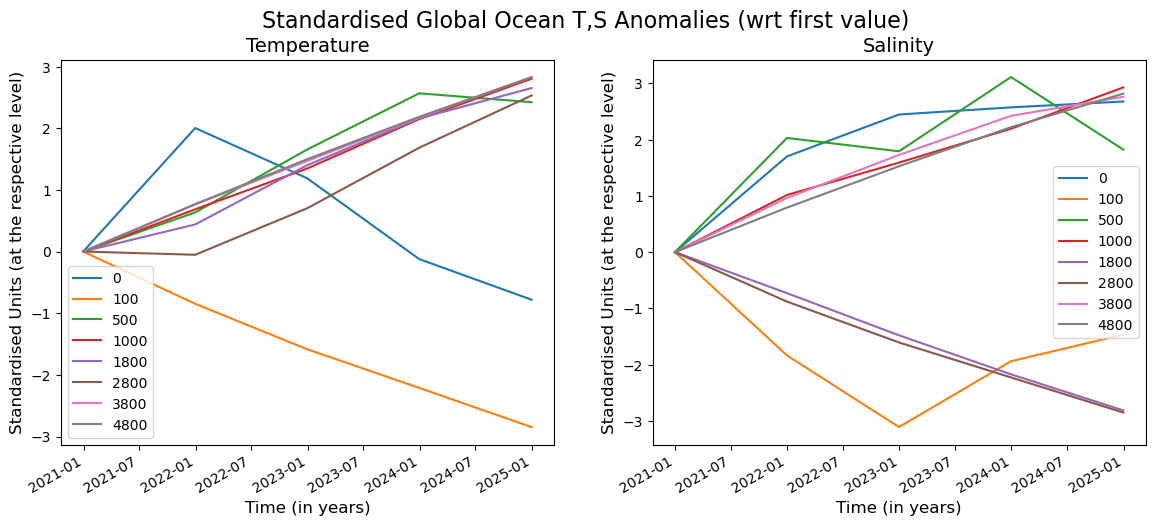

In [6]:
# This block is to produce plots with global mean timeseries at different depths

# First we do it for the full values
## fn.time_series(global_mean,'Global Ocean',customise_level=False, levels=list, outputfig="./figs")
# Second for the anomalies with respect to the first value 
fn.time_series(global_mean_anom_t0,'Global Ocean',customise_level=False, levels=list, outputfig="./figs")
# And third for the standardised anomalies
fn.time_series(global_mean_anom_t0_std,'Global Ocean',customise_level=False, levels=list, outputfig="./figs")








2023-07-07 13:41:43,274 - INFO - ./figs/TS_time_series_fullvalue_global_ocean.png saved


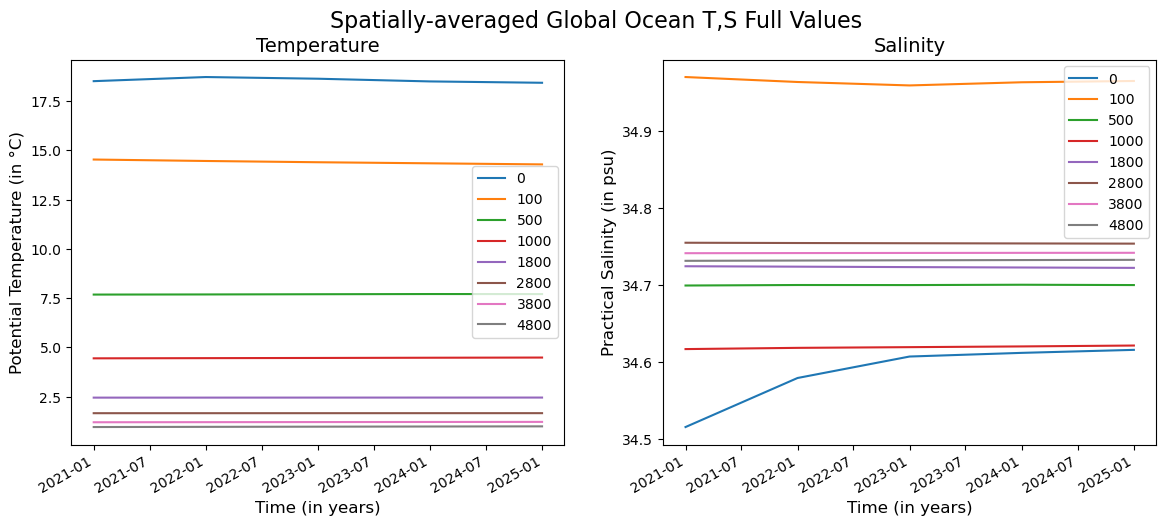

2023-07-07 13:42:48,455 - INFO - ./figs/TS_time_series_anomaly_global_ocean.png saved


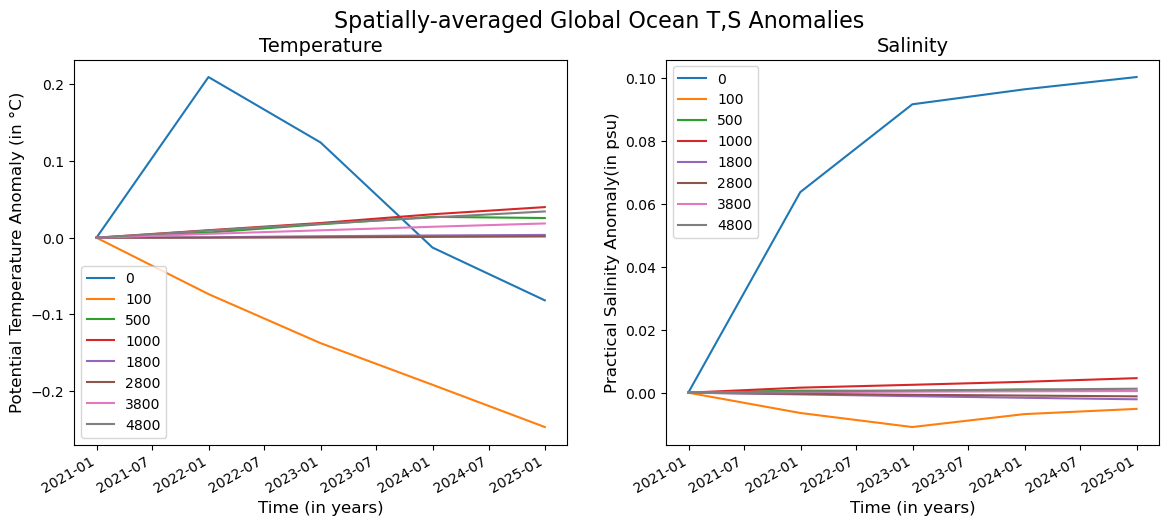

2023-07-07 13:43:56,279 - INFO - ./figs/TS_time_series_stdanomaly_global_ocean.png saved


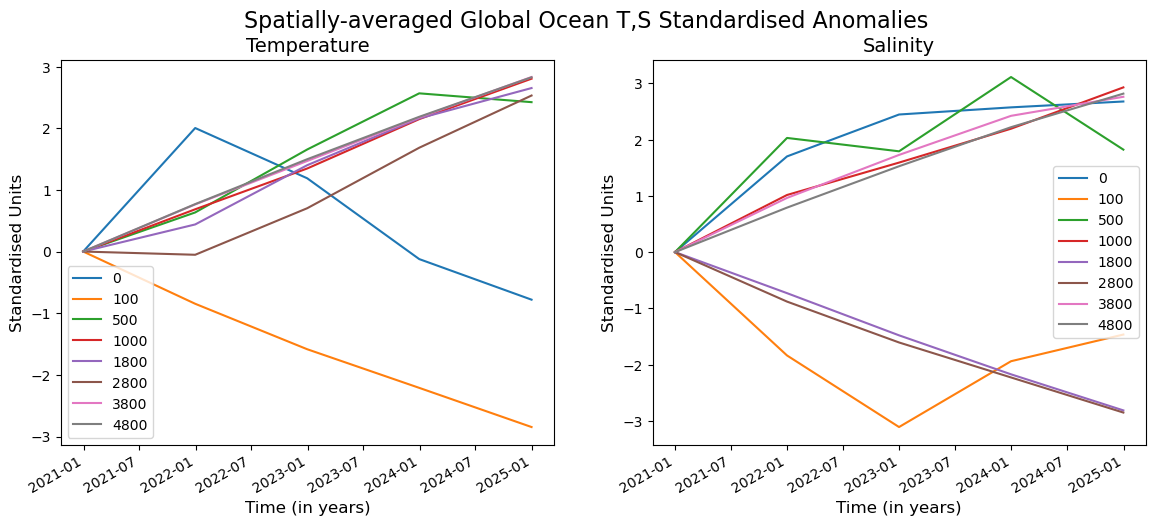

In [6]:
# This block is to produce plots with global mean timeseries at different depths

# First we do it for the full values
fn.time_series_custom(global_mean,'Global Ocean',type="FullValue",customise_level=False, levels=list, outputfig="./figs")
# Second for the anomalies with respect to the first value 
fn.time_series_custom(global_mean_anom_t0,'Global Ocean',type="Anomaly",customise_level=False, levels=list, outputfig="./figs")
# And third for the standardised anomalies
fn.time_series_custom(global_mean_anom_t0_std,'Global Ocean',type="StdAnomaly",customise_level=False, levels=list, outputfig="./figs")


In [96]:
# This function was copied from https://stackoverflow.com/questions/52108417/how-to-apply-linear-regression-to-every-pixel-in-a-large-multi-dimensional-array
#  and is a very efficient way to compute trends in 3D arrays
def linregress_3D(y_array):
    # y_array is a 3-D array formatted like (time,lon,lat)
    # The purpose of this function is to do linear regression using time series of data over each (lon,lat) grid box with consideration of ignoring np.nan
    # Construct x_array indicating time indexes of y_array, namely the independent variable.
    x_array=np.empty(y_array.shape)
    for i in range(y_array.shape[0]): x_array[i,:,:]=i+1 # This would be fine if time series is not too long. Or we can use i+yr (e.g. 2019).
    x_array[np.isnan(y_array)]=np.nan
    # Compute the number of non-nan over each (lon,lat) grid box.
    n=np.sum(~np.isnan(x_array),axis=0)
    # Compute mean and standard deviation of time series of x_array and y_array over each (lon,lat) grid box.
    x_mean=np.nanmean(x_array,axis=0)
    y_mean=np.nanmean(y_array,axis=0)
    x_std=np.nanstd(x_array,axis=0)
    y_std=np.nanstd(y_array,axis=0)
    # Compute co-variance between time series of x_array and y_array over each (lon,lat) grid box.
    cov=np.nansum((x_array-x_mean)*(y_array-y_mean),axis=0)/n
    # Compute correlation coefficients between time series of x_array and y_array over each (lon,lat) grid box.
    cor=cov/(x_std*y_std)
    # Compute slope between time series of x_array and y_array over each (lon,lat) grid box.
    slope=cov/(x_std**2)
    # Compute intercept between time series of x_array and y_array over each (lon,lat) grid box.
    intercept=y_mean-x_mean*slope
    # Compute tstats, stderr, and p_val between time series of x_array and y_array over each (lon,lat) grid box.
    tstats=cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr=slope/tstats
    from scipy.stats import t
    p_val=t.sf(tstats,n-2)*2
    # Compute r_square and rmse between time series of x_array and y_array over each (lon,lat) grid box.
    # r_square also equals to cor**2 in 1-variable lineare regression analysis, which can be used for checking.
    r_square=np.nansum((slope*x_array+intercept-y_mean)**2,axis=0)/np.nansum((y_array-y_mean)**2,axis=0)
    rmse=np.sqrt(np.nansum((y_array-slope*x_array-intercept)**2,axis=0)/n)
    # Do further filteration if needed (e.g. We stipulate at least 3 data records are needed to do regression analysis) and return values
    n=n*1.0 # convert n from integer to float to enable later use of np.nan
    n[n<3]=np.nan
    slope[np.isnan(n)]=np.nan
    intercept[np.isnan(n)]=np.nan
    p_val[np.isnan(n)]=np.nan
    r_square[np.isnan(n)]=np.nan
    rmse[np.isnan(n)]=np.nan
    return n,slope,intercept,p_val,r_square,rmse

time=yearly_data.time.dt.year.values
y=yearly_data.ocpt[:,1,:,:]
#kk = stats.linregress(time, yearly_data.ocpt[:,:,:,:])
#print(kk.slope)
n,slope,intercept,p_val,r_square,rmse=linregress_3D(y)

In [10]:
#atlantic_mean_anom = fn.std_anom_wrt_initial(yearly_data,region="Atlantic Ocean")
#pacific_mean_anom = fn.std_anom_wrt_initial(yearly_data,region="Pacific Ocean")
#indian_mean_anom = fn.std_anom_wrt_initial(yearly_data, region="Indian Ocean")
#arctic_mean_anom = fn.std_anom_wrt_initial(yearly_data, region="Arctic Ocean")
#southern_mean_anom = fn.std_anom_wrt_initial(yearly_data, region="Southern Ocean")

2023-07-07 09:49:51,489 - INFO -  data slicing for this region, latitude -35.0 to 65.0, longitude -80.0 to 30.0
2023-07-07 09:49:51,527 - INFO -  data slicing for this region, latitude -55.0 to 65.0, longitude 120.0 to 290.0
2023-07-07 09:49:51,560 - INFO -  data slicing for this region, latitude -30.0 to 30.0, longitude 100.0 to 300.0
2023-07-07 09:49:51,592 - INFO -  data slicing for this region, latitude 65.0 to 90.0, longitude 0.0 to 360.0
2023-07-07 09:49:51,624 - INFO -  data slicing for this region, latitude -80.0 to -55.0, longitude -180.0 to 180.0


In [1]:
#fn.ocpt_so_anom_plot(global_mean_anom,"Global Ocean", outputfig)
#fn.ocpt_so_anom_plot(atlantic_mean_anom,"Atlantic Ocean", outputfig)
#fn.ocpt_so_anom_plot(pacific_mean_anom,"Pacific Ocean", outputfig)
#fn.ocpt_so_anom_plot(indian_mean_anom,"Indian Ocean", outputfig)
#fn.ocpt_so_anom_plot(arctic_mean_anom,"Arctic Ocean", outputfig)
#fn.ocpt_so_anom_plot(southern_mean_anom,"Southern Ocean", outputfig)

type: Custom levels are selected, but levels are not provided.

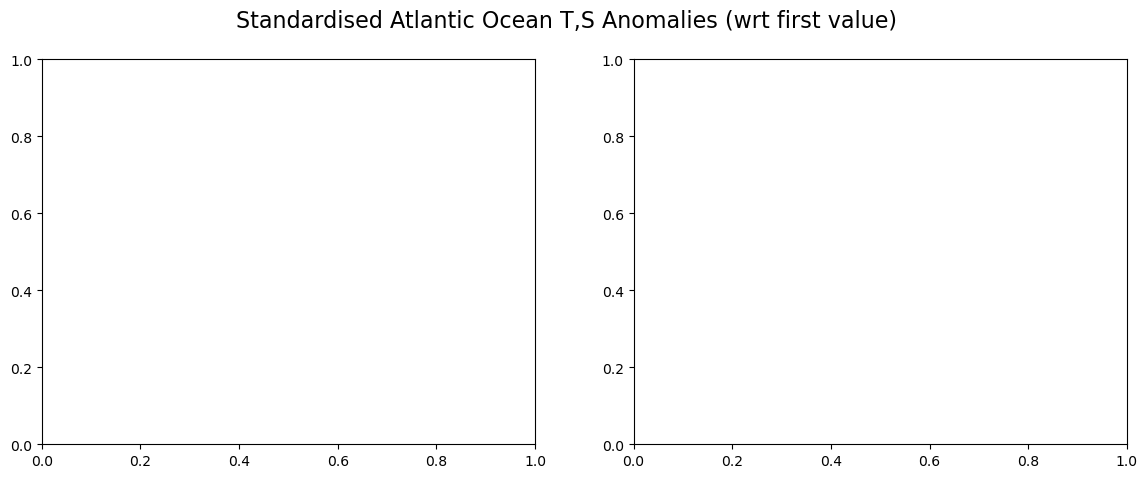

In [11]:
fn.time_series(global_mean_anom,'Global Ocean',customise_level=False, levels=list, outputfig)
fn.time_series(atlantic_mean_anom,'Atlantic Ocean', outputfig)
fn.time_series(pacific_mean_anom,'Pacific Ocean', outputfig)
fn.time_series(indian_mean_anom,'Indian Ocean', outputfig)
fn.time_series(arctic_mean_anom,'Arctic Ocean', outputfig)
fn.time_series(southern_mean_anom,'Southern Ocean', outputfig)